In [1055]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

%matplotlib inline

In [1056]:
kc = pd.read_csv('kc_house_data.csv')

In [1057]:
kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


Variables with High Correlation to Price > .5 
- bathrooms .52
- sqft_living .70
- grade .66
- sqft_above .60
- sqft_living15 .59

In [1307]:
check_kc = kc[['price','bathrooms','sqft_living','grade','sqft_above','sqft_living15']]

In [1308]:
check_kc.describe()

price     bathrooms   sqft_living         grade    sqft_above  \
count  2.159700e+04  21597.000000  21597.000000  21597.000000  21597.000000   
mean   5.402966e+05      2.115826   2080.321850      4.657915   1788.596842   
std    3.673681e+05      0.768984    918.106125      1.173200    827.759761   
min    7.800000e+04      0.500000    370.000000      0.000000    370.000000   
25%    3.220000e+05      1.750000   1430.000000      4.000000   1190.000000   
50%    4.500000e+05      2.250000   1910.000000      4.000000   1560.000000   
75%    6.450000e+05      2.500000   2550.000000      5.000000   2210.000000   
max    7.700000e+06      8.000000  13540.000000     10.000000   9410.000000   

       sqft_living15  
count   21597.000000  
mean     1986.620318  
std       685.230472  
min       399.000000  
25%      1490.000000  
50%      1840.000000  
75%      2360.000000  
max      6210.000000

In [1309]:
check_kc.isnull().sum()

price            0
bathrooms        0
sqft_living      0
grade            0
sqft_above       0
sqft_living15    0
dtype: int64

## Checking for multicollinearity

Because the idea behind regression is that you can change one variable and keep the others constant, correlation is a problem, because it indicates that changes in one predictor are associated with changes in another one as well. Because of this, the estimates of the coefficients can have big fluctuations as a result of small changes in the model. As a result, you may not be able to interpret the coefficients reliably or trust the p-values associated with correlated predictors.

In [1310]:
abs(check_kc.corr()) > .8

price  bathrooms  sqft_living  grade  sqft_above  sqft_living15
price           True      False        False  False       False          False
bathrooms      False       True        False  False       False          False
sqft_living    False      False         True  False        True          False
grade          False      False        False   True       False          False
sqft_above     False      False         True  False        True          False
sqft_living15  False      False        False  False       False           True

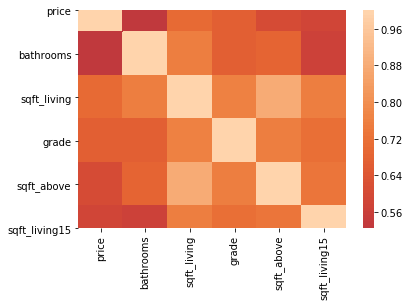

In [1311]:
import seaborn as sns
sns.heatmap(check_kc.corr(), center=0);

- sqft_living and sqft_above highly correlated 
- dropping sqft_above to avoid multi collinearity

In [1312]:
check_kc.drop(['sqft_above'], axis=1, inplace = True)

/Users/findlaybowditch/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


/Users/findlaybowditch/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


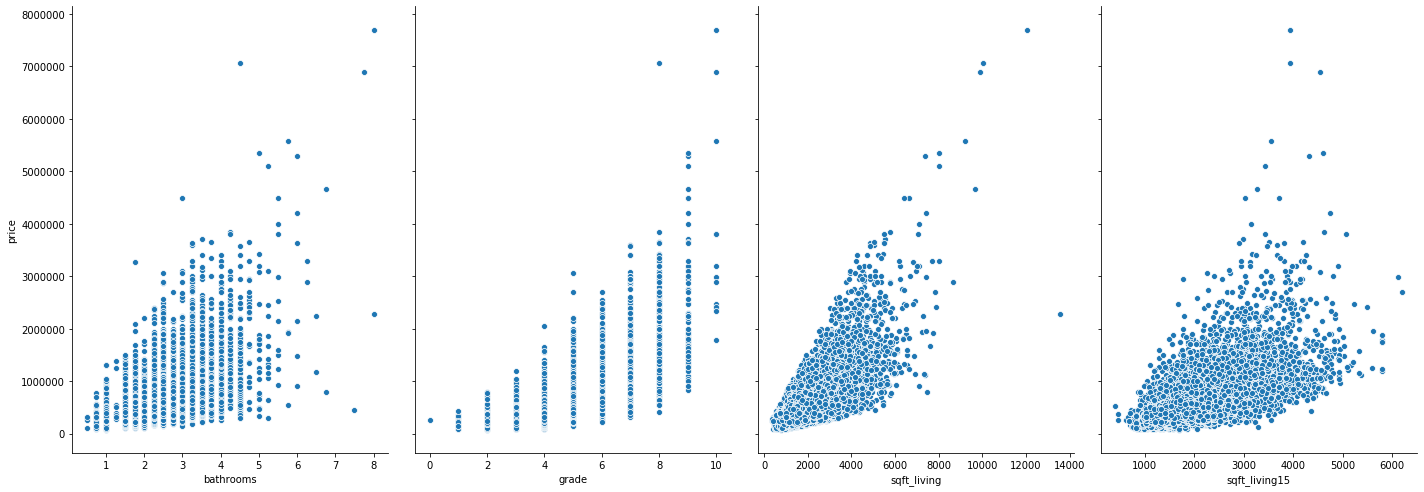

In [1313]:
sns.pairplot(check_kc, x_vars=['bathrooms','grade','sqft_living','sqft_living15'], y_vars='price', size=7, aspect=0.7)

# Run linear regression model with top correlated variables

In [1316]:
check_kc.head()

price  bathrooms  sqft_living  grade  sqft_living15
0  221900.0       1.00         1180      4           1340
1  538000.0       2.25         2570      4           1690
2  180000.0       1.00          770      3           2720
3  604000.0       3.00         1960      4           1360
4  510000.0       2.00         1680      5           1800

In [1372]:
lr_model = ols(formula='price~sqft_living+grade', data=check_kc).fit()

In [1373]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                 1.241e+04
Date:                Mon, 02 Dec 2019   Prob (F-statistic):               0.00
Time:                        08:20:18   Log-Likelihood:            -2.9913e+05
No. Observations:               21597   AIC:                         5.983e+05
Df Residuals:                   21594   BIC:                         5.983e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    -3.05e+05   7265.784    -41.983      0.000   -3.19e+05   -2.91e+05
sqft_living   184.1215      2.872     64.102      0.000     178.491     189.751
grade        9.925e+04   2247.784     44.155      0.000    9.48e+04    1.04e+05
==============================================================================
Omnibus:                    16960.955   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1005795.090
Skew:                           3.304   Prob(JB):                         0.00
Kurtosis:                      35.773   Cond. No.                     1.00e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  1e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# train/test

In [1375]:
x = check_kc[['sqft_living','grade']]
y = check_kc['price']

In [1376]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [1377]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

17277 4320 17277 4320


In [1378]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [1379]:
linreg.score(X_train,y_train)

0.5363690098946963

In [1380]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [1381]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 63114105973.6789
Test Mean Squarred Error: 61550769137.98828


## Cross Validatation

In [1382]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

cv_5_results  = np.mean(cross_val_score(linreg, x, y, cv=5,  scoring='neg_mean_squared_error'))
cv_10_results = np.mean(cross_val_score(linreg, x, y, cv=10, scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linreg, x, y, cv=20, scoring='neg_mean_squared_error'))

In [1383]:
print(cv_5_results)
print(cv_10_results)  
print(cv_20_results)

-62920900335.722244
-62958096526.03639
-62904214567.185


In [1340]:
def print_accuracy_report(classifier, x, y, num_validations=5):
    accuracy = cross_validation.cross_val_score(classifier, 
            x, y, scoring='accuracy', cv=num_validations)
    print ("Accuracy: " + str(round(100*accuracy.mean(), 2)) + "%")

[2 3] [0 1]
[0 1] [2 3]


# Adding dummy zipcode

In [1386]:
check_kc_dums = pd.concat([check_kc, zipdums], axis = 1)

In [1387]:
lr_model = ols(formula='price~sqft_living+grade+zipdums', data=check_kc).fit()

In [1390]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     884.0
Date:                Mon, 02 Dec 2019   Prob (F-statistic):               0.00
Time:                        08:30:25   Log-Likelihood:            -2.9265e+05
No. Observations:               21597   AIC:                         5.854e+05
Df Residuals:                   21525   BIC:                         5.860e+05
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -3.612e+05   1.12e+04    -32.243      0.000   -3.83e+05   -3.39e+05
sqft_living   196.8729      2.199     89.548      0.000     192.564     201.182
grade        6.228e+04   1771.302     35.161      0.000    5.88e+04    6.58e+04
zipdums[0]   4.498e+04   1.64e+04      2.737      0.006    1.28e+04    7.72e+04
zipdums[1]  -7374.1429   1.48e+04     -0.498      0.619   -3.64e+04    2.17e+04
zipdums[2]   7.908e+05   1.44e+04     54.829      0.000    7.63e+05    8.19e+05
zipdums[3]   3.066e+05   1.74e+04     17.592      0.000    2.72e+05    3.41e+05
zipdums[4]   2.916e+05    1.3e+04     22.448      0.000    2.66e+05    3.17e+05
zipdums[5]   2.397e+05   1.85e+04     12.964      0.000    2.03e+05    2.76e+05
zipdums[6]    2.97e+05   1.48e+04     20.105      0.000    2.68e+05    3.26e+05
zipdums[7]   8.999e+04    2.1e+04      4.282      0.000    4.88e+04    1.31e+05
zipdums[8]   1.106e+05   1.65e+04      6.690      0.000    7.82e+04    1.43e+05
zipdums[9]   1.266e+05   1.94e+04      6.540      0.000    8.87e+04    1.65e+05
zipdums[10]  7.757e+04   1.67e+04      4.653      0.000    4.49e+04     1.1e+05
zipdums[11]  5.613e+04   1.56e+04      3.592      0.000    2.55e+04    8.68e+04
zipdums[12] -2.873e+04   1.29e+04     -2.235      0.025   -5.39e+04   -3537.689
zipdums[13]  1.948e+05    2.3e+04      8.474      0.000     1.5e+05     2.4e+05
zipdums[14]    1.6e+05   1.35e+04     11.893      0.000    1.34e+05    1.86e+05
zipdums[15]  1.186e+05   1.48e+04      8.029      0.000    8.96e+04    1.48e+05
zipdums[16]  1.881e+05   1.43e+04     13.116      0.000     1.6e+05    2.16e+05
zipdums[17] -3894.5687   1.52e+04     -0.256      0.798   -3.37e+04    2.59e+04
zipdums[18]  9007.0254   1.49e+04      0.604      0.546   -2.02e+04    3.82e+04
zipdums[19]  1.222e+04   1.93e+04      0.633      0.527   -2.56e+04    5.01e+04
zipdums[20]  3.802e+05   1.33e+04     28.597      0.000    3.54e+05    4.06e+05
zipdums[21]  2.127e+05   1.26e+04     16.853      0.000    1.88e+05    2.37e+05
zipdums[22]    1.9e+04   1.24e+04      1.528      0.127   -5375.867    4.34e+04
zipdums[23]  1.366e+06   2.82e+04     48.378      0.000    1.31e+06    1.42e+06
zipdums[24]  5.732e+05   1.49e+04     38.390      0.000    5.44e+05    6.02e+05
zipdums[25]  7091.4072   1.26e+04      0.562      0.574   -1.76e+04    3.18e+04
zipdums[26]   1.05e+05   1.59e+04      6.602      0.000    7.39e+04    1.36e+05
zipdums[27]  2.178e+05   1.25e+04     17.364      0.000    1.93e+05    2.42e+05
zipdums[28]  1.937e+05   1.35e+04     14.311      0.000    1.67e+05     2.2e+05
zipdums[29]  5.684e+04    1.5e+04      3.791      0.000    2.75e+04    8.62e+04
zipdums[30]  1.138e+05   1.35e+04      8.456      0.000    8.74e+04     1.4e+05
zipdums[31]  2.713e+04   1.31e+04      2.069      0.039    1431.241    5.28e+04
zipdums[32]  7.685e+04   1.31e+04      5.88

# Looking at other variables - initial changes made below

 #### Date

In [1058]:
kc['date'] = pd.to_datetime(kc['date'])

#### Sqft_Basement - Binary (0,1)


In [1059]:
kc['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
2810.0        1
243.0         1
1816.0        1
1960.0        1
2720.0        1
Name: sqft_basement, Length: 304, dtype: int64

In [1060]:
kc['sqft_basement'].replace({'?': 0}, inplace = True)

In [1061]:
##changed to float and all values over 0 to 1 - if basement yes if not no

In [1062]:
kc['sqft_basement'] = kc['sqft_basement'].astype(float)

In [1063]:
kc['sqft_basement'].values[kc['sqft_basement'].values > 0] = 1

In [1064]:
kc['sqft_basement'].dtype

dtype('float64')

#### Waterfront - Binary (0,1)

In [1065]:
# replaced NaN with 0 --> Binary (1,0) For view of waterfront

In [1066]:
kc['waterfront'].fillna(0, inplace = True) 

In [1067]:
kc['waterfront'].dtype

dtype('float64')

#### Grade

In [1068]:
kc['grade'].value_counts()

7     8974
8     6065
9     2615
6     2038
10    1134
11     399
5      242
12      89
4       27
13      13
3        1
Name: grade, dtype: int64

In [1069]:
kc['grade'] = kc['grade'].apply(lambda x: x -3)

#### View (Tour Rating)

In [1070]:
kc['view'].value_counts()

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

In [1071]:
kc['view'].isnull().sum()

63

In [1072]:
kc['view'].fillna(0, inplace = True) 

In [1073]:
kc['condition'].value_counts()

3    14020
4     5677
5     1701
2      170
1       29
Name: condition, dtype: int64

#### Year Built 

In [1074]:
kc['yr_built'].describe()

count    21597.000000
mean      1970.999676
std         29.375234
min       1900.000000
25%       1951.000000
50%       1975.000000
75%       1997.000000
max       2015.000000
Name: yr_built, dtype: float64

In [1075]:
kc['yr_built'].isnull().sum()

0

In [1076]:
##### Change Year Built to 'How Old'

In [1077]:
kc['yr_built'] = kc['yr_built'].apply(lambda x: 2015-x)

In [1078]:
kc['yr_built'].describe()

count    21597.000000
mean        44.000324
std         29.375234
min          0.000000
25%         18.000000
50%         40.000000
75%         64.000000
max        115.000000
Name: yr_built, dtype: float64

#### yr_renovated - binary (0,1)

In [1079]:
kc['yr_renovated'].isnull().sum()

3842

In [1080]:
kc['yr_renovated'].fillna(0, inplace = True) 

In [1081]:
kc['yr_renovated'].values[kc['yr_renovated'].values > 0] = 1

In [1082]:
kc['yr_renovated'].value_counts()

0.0    20853
1.0      744
Name: yr_renovated, dtype: int64

# Dropping Columns

In [1083]:
kc.drop(['id','lat','long'], axis = 1, inplace = True)

# Looking at Distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c39d3aed0>,
      dtype=object)

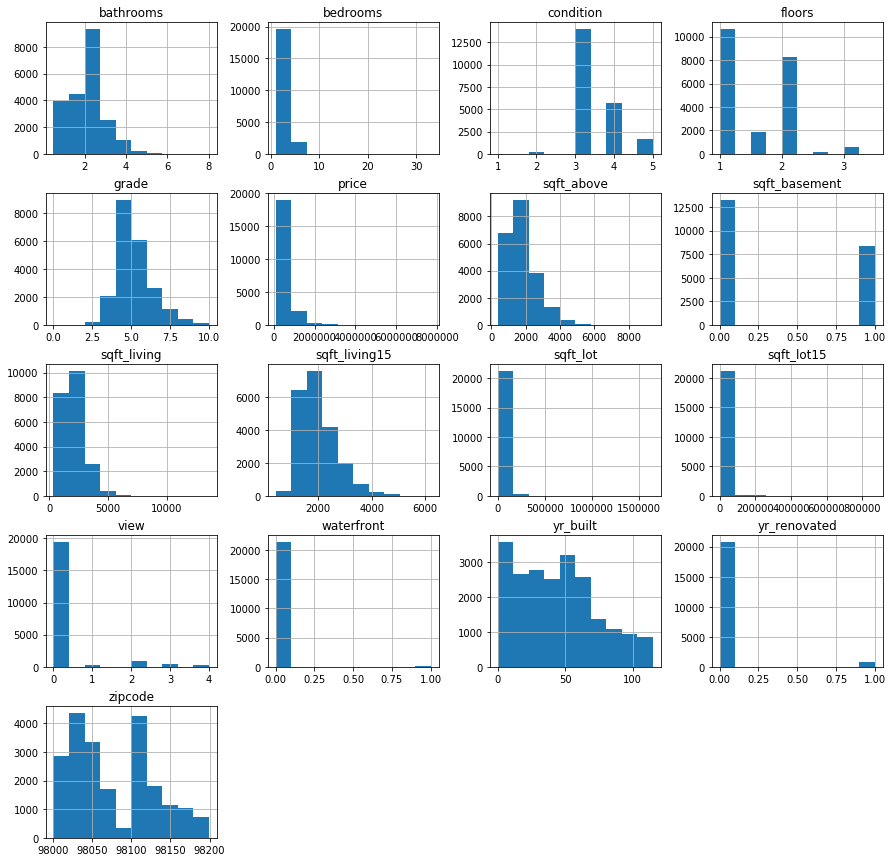

In [1084]:
kc.hist(figsize  = [15, 15])

### Applying Log Transformation

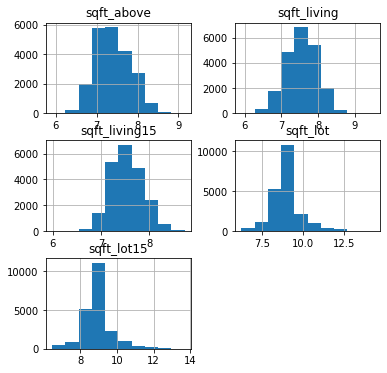

In [1085]:
data_log = pd.DataFrame([])
data_log['sqft_above'] = np.log(kc['sqft_above'])
data_log['sqft_living'] = np.log(kc['sqft_living'])
data_log['sqft_living15'] = np.log(kc['sqft_living15'])
data_log['sqft_lot'] = np.log(kc['sqft_lot'])
data_log['sqft_lot15'] = np.log(kc['sqft_lot15'])
data_log.hist(figsize  = [6, 6]);

In [1086]:
kc['sqft_abovelog'] = np.log(kc['sqft_above'])
kc['sqft_livinglog'] = np.log(kc['sqft_living'])
kc['sqft_living15log'] = np.log(kc['sqft_living15'])
kc['sqft_lotlog'] = np.log(kc['sqft_lot'])
kc['sqft_lot15log'] = np.log(kc['sqft_lot15'])

#### Zipcode

In [1384]:
kc['zipcode'] = kc['zipcode'].astype('category')

In [1385]:
zipdums = pd.get_dummies(kc['zipcode'], drop_first=True)

# Scaling 

In [1091]:
numeric_features = ['bedrooms', 'bathrooms', 'sqft_livinglog', 'sqft_lotlog','floors','view','condition','grade','sqft_abovelog','yr_built','sqft_living15log','sqft_lot15log']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

x = pd.DataFrame(numeric_transformer.fit_transform(kc[numeric_features]),columns = numeric_features)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c3d51a0d0>,
      dtype=object)

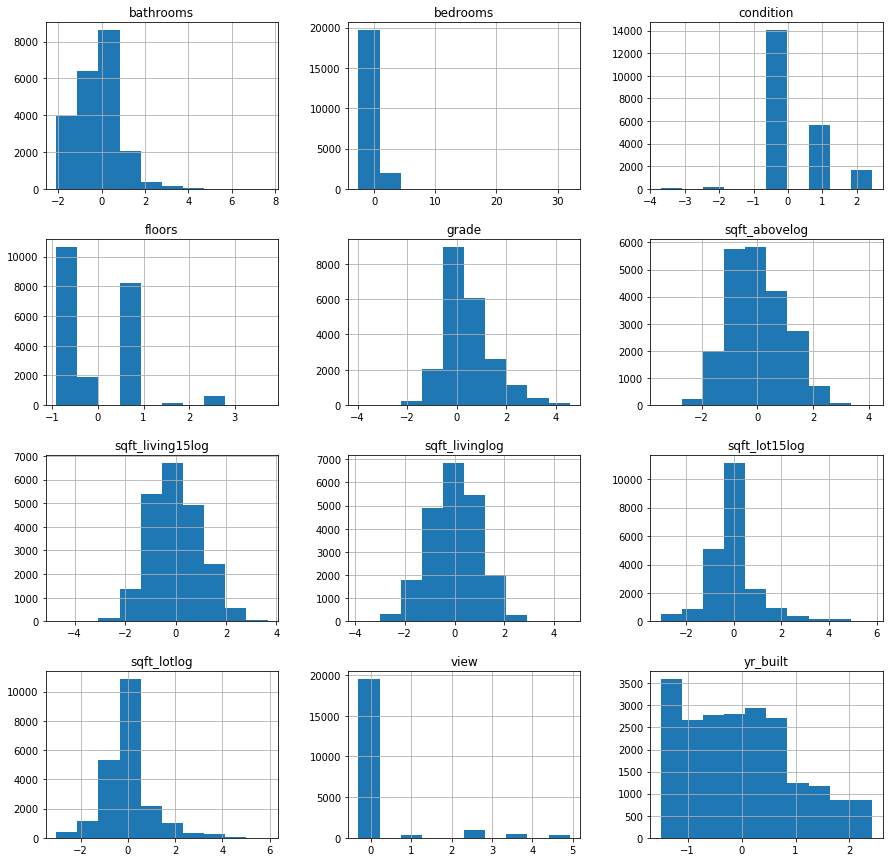

In [1092]:
x.hist(figsize = [15,15])

In [1093]:
kc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 23 columns):
date                21597 non-null datetime64[ns]
price               21597 non-null float64
bedrooms            21597 non-null int64
bathrooms           21597 non-null float64
sqft_living         21597 non-null int64
sqft_lot            21597 non-null int64
floors              21597 non-null float64
waterfront          21597 non-null float64
view                21597 non-null float64
condition           21597 non-null int64
grade               21597 non-null int64
sqft_above          21597 non-null int64
sqft_basement       21597 non-null float64
yr_built            21597 non-null int64
yr_renovated        21597 non-null float64
zipcode             21597 non-null int64
sqft_living15       21597 non-null int64
sqft_lot15          21597 non-null int64
sqft_abovelog       21597 non-null float64
sqft_livinglog      21597 non-null float64
sqft_living15log    21597 non-null float64
s

# Combining Dataframe

In [1095]:
binary = kc[['waterfront','sqft_basement','yr_renovated']]
price = kc['price']

#### Combinng Price, Category Variables, Scaled Numeric Variables, ZipCode Dummys

In [1098]:
DF = pd.concat([price, binary, x, zipdums], axis = 1)

In [1106]:
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 85 columns):
price               21597 non-null float64
waterfront          21597 non-null float64
sqft_basement       21597 non-null float64
yr_renovated        21597 non-null float64
bedrooms            21597 non-null float64
bathrooms           21597 non-null float64
sqft_livinglog      21597 non-null float64
sqft_lotlog         21597 non-null float64
floors              21597 non-null float64
view                21597 non-null float64
condition           21597 non-null float64
grade               21597 non-null float64
sqft_abovelog       21597 non-null float64
yr_built            21597 non-null float64
sqft_living15log    21597 non-null float64
sqft_lot15log       21597 non-null float64
98002               21597 non-null uint8
98003               21597 non-null uint8
98004               21597 non-null uint8
98005               21597 non-null uint8
98006               21597 non-null uint

# Running Linear Regression Model

###### lr_model = ols(formula='price~waterfront+sqft_basement+yr_renovated+bedrooms+bathrooms+floors+view+condition+grade+yr_built+zipdums+sqft_abovelog+sqft_livinglog+sqft_living15log+sqft_lotlog+sqft_lot15log', data=DF).fit()  

In [1304]:
lr_model = ols(formula='price~zipdums+bathrooms+condition+view+grade+sqft_livinglog', data=DF).fit()

In [1305]:
lr_model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     799.6
Date:                Sun, 01 Dec 2019   Prob (F-statistic):               0.00
Time:                        20:16:19   Log-Likelihood:            -2.9312e+05
No. Observations:               21597   AIC:                         5.864e+05
Df Residuals:                   21522   BIC:                         5.870e+05
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       3.463e+05      1e+04     34.566      0.000    3.27e+05    3.66e+05
zipdums[0]      4.089e+04   1.68e+04      2.432      0.015    7935.096    7.39e+04
zipdums[1]     -2.643e+04   1.51e+04     -1.746      0.081   -5.61e+04    3245.908
zipdums[2]      8.239e+05   1.47e+04     55.858      0.000    7.95e+05    8.53e+05
zipdums[3]      3.237e+05   1.79e+04     18.133      0.000    2.89e+05    3.59e+05
zipdums[4]      2.754e+05   1.33e+04     20.681      0.000    2.49e+05    3.01e+05
zipdums[5]      2.364e+05   1.89e+04     12.497      0.000    1.99e+05    2.73e+05
zipdums[6]      2.575e+05   1.51e+04     17.021      0.000    2.28e+05    2.87e+05
zipdums[7]      1.108e+05   2.15e+04      5.159      0.000    6.87e+04    1.53e+05
zipdums[8]      1.278e+05   1.69e+04      7.563      0.000    9.47e+04    1.61e+05
zipdums[9]      1.546e+05   1.98e+04      7.812      0.000    1.16e+05    1.93e+05
zipdums[10]     1.057e+05   1.71e+04      6.197      0.000    7.22e+04    1.39e+05
zipdums[11]    -7610.7010    1.6e+04     -0.475      0.635    -3.9e+04    2.38e+04
zipdums[12]    -3.384e+04   1.31e+04     -2.575      0.010   -5.96e+04   -8085.528
zipdums[13]     2.307e+05   2.35e+04      9.820      0.000    1.85e+05    2.77e+05
zipdums[14]     1.777e+05   1.38e+04     12.923      0.000    1.51e+05    2.05e+05
zipdums[15]     1.196e+05   1.51e+04      7.921      0.000       9e+04    1.49e+05
zipdums[16]     1.802e+05   1.47e+04     12.286      0.000    1.51e+05    2.09e+05
zipdums[17]    -1126.3589   1.55e+04     -0.073      0.942   -3.16e+04    2.93e+04
zipdums[18]     4573.6095   1.53e+04      0.300      0.764   -2.53e+04    3.45e+04
zipdums[19]     6437.7175   1.97e+04      0.326      0.744   -3.23e+04    4.51e+04
zipdums[20]     3.748e+05   1.36e+04     27.567      0.000    3.48e+05    4.01e+05
zipdums[21]      1.99e+05   1.29e+04     15.422      0.000    1.74e+05    2.24e+05
zipdums[22]     3.229e+04   1.27e+04      2.538      0.011    7349.836    5.72e+04
zipdums[23]     1.459e+06   2.88e+04     50.588      0.000     1.4e+06    1.52e+06
zipdums[24]      5.55e+05   1.53e+04     36.241      0.000    5.25e+05    5.85e+05
zipdums[25]     9091.1221   1.29e+04      0.705      0.481   -1.62e+04    3.44e+04
zipdums[26]     1.017e+05   1.63e+04      6.253      0.000    6.98e+04    1.34e+05
zipdums[27]     2.274e+05   1.28e+04     17.731      0.000    2.02e+05    2.52e+05
zipdums[28]     2.433e+05   1.38e+04     17.580      0.000    2.16e+05     2.7e+05
zipdums[29]     5.538e+04   1.53e+04      3.613      0.000    2.53e+04    8.54e+04
zipdums[30]     1.061e+05   1.38e+04      7.703      0.000    7.91e+04    1.33e+05
zipdums[31]     3.375e+04   1.34e+04      2.517      0.012    7470.482       6e+04
zipdums[32]     1.045e+05   1.33e+04      7.832      0.000    7.84e+04    1.31e+05
zipdums[33] 

In [1190]:
new_predictors = predictors[['waterfront','sqft_livinglog','bathrooms','floors','view','grade','sqft_abovelog','sqft_living15log']]

In [1193]:
abs(new_predictors.corr()) > .7

waterfront  sqft_livinglog  bathrooms  floors   view  grade  \
waterfront              True           False      False   False  False  False   
sqft_livinglog         False            True       True   False  False   True   
bathrooms              False            True       True   False  False  False   
floors                 False           False      False    True  False  False   
view                   False           False      False   False   True  False   
grade                  False            True      False   False  False   True   
sqft_abovelog          False            True      False   False  False   True   
sqft_living15log       False            True      False   False  False  False   

                  sqft_abovelog  sqft_living15log  
waterfront                False             False  
sqft_livinglog             True              True  
bathrooms                 False             False  
floors                    False             False  
view                      False             False  
grade                      True             False  
sqft_abovelog              True              True  
sqft_living15log           True              True

# Which Variables Are Most Important? Stepwise 

In [1129]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [1131]:
predictors = DF[['waterfront',    'sqft_basement',     'yr_renovated',
               'bedrooms',        'bathrooms',   'sqft_livinglog',
            'sqft_lotlog',           'floors',             'view',
              'condition',            'grade',    'sqft_abovelog',
               'yr_built', 'sqft_living15log',    'sqft_lot15log',]]

In [1132]:
result = stepwise_selection(predictors, DF['price'], verbose=True)
print('resulting features:')
print(result)

/Users/findlaybowditch/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Add  waterfront                     with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  yr_built                       with p-value 0.0
Add  grade                          with p-value 0.0
Add  view                           with p-value 6.49152e-137
Add  sqft_livinglog                 with p-value 4.34863e-65
Add  sqft_living15log               with p-value 1.28916e-21
Add  sqft_lot15log                  with p-value 1.42133e-25
Add  bedrooms                       with p-value 3.51367e-16
Add  condition                      with p-value 2.86738e-12
Add  sqft_abovelog                  with p-value 1.5078e-06
Add  sqft_basement                  with p-value 2.75847e-22
Drop sqft_livinglog                 with p-value 0.271357
Add  yr_renovated                   with p-value 0.0035962
resulting features:
['waterfront', 'bathrooms', 'yr_built', 'grade', 'view', 'sqft_living15log', 'sqft_lot15log', 'bedrooms', 'condition', 'sqft_abovelog', 'sqft_basement', 'yr_renova

/Users/findlaybowditch/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.


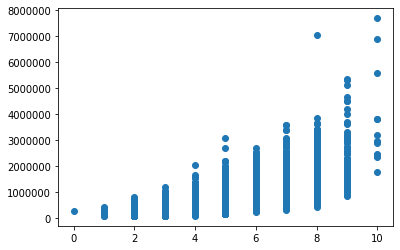

In [627]:
x = kc2['grade']
y = kc2['price']

plt.scatter(x,y)

#### The problem with 𝑅2 is that, whichever predictor you add to your model irrespective of whether it will add any new information to the model, will increase your 𝑅2 value. That is, the model tends to overfit if we only use 𝑅2 as our model fitting criterion. This is why train-has test split is essential and why regularization techniques are used to refine more advanced regression models. Make sure to read this blogpost on the difference between the two to get a better sense to why use  𝑅2𝑎𝑑𝑗

# Feature Ranking

In [1123]:
predictors = DF[['waterfront',    'sqft_basement',     'yr_renovated',
               'bedrooms',        'bathrooms',   'sqft_livinglog',
            'sqft_lotlog',           'floors',             'view',
              'condition',            'grade',    'sqft_abovelog',
               'yr_built', 'sqft_living15log',    'sqft_lot15log',]]

In [1126]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select=7)
selector = selector.fit(predictors, DF['price'])

In [1127]:
selector.ranking_

array([1, 1, 5, 4, 1, 7, 9, 8, 1, 6, 1, 1, 1, 2, 3])

In [1128]:
predictors.columns

Index(['waterfront', 'sqft_basement', 'yr_renovated', 'bedrooms', 'bathrooms',
       'sqft_livinglog', 'sqft_lotlog', 'floors', 'view', 'condition', 'grade',
       'sqft_abovelog', 'yr_built', 'sqft_living15log', 'sqft_lot15log'],
      dtype='object')

#### Ranked 
- 1. Sqft_livinglog 2. grade  3. sqft_living15log 4. bathrooms

In [491]:
x1 = predictors2.drop(['sqft_living','sqft_living15'], axis = 1)

In [492]:
x1.columns

Index(['bathrooms', 'grade', 'sqft_livinglog', 'sqft_living15log'], dtype='object')

# Regression Model Validation

In [1218]:
DF.columns

Index([           'price',       'waterfront',    'sqft_basement',
           'yr_renovated',         'bedrooms',        'bathrooms',
         'sqft_livinglog',      'sqft_lotlog',           'floors',
                   'view',        'condition',            'grade',
          'sqft_abovelog',         'yr_built', 'sqft_living15log',
          'sqft_lot15log',              98002,              98003,
                    98004,              98005,              98006,
                    98007,              98008,              98010,
                    98011,              98014,              98019,
                    98022,              98023,              98024,
                    98027,              98028,              98029,
                    98030,              98031,              98032,
                    98033,              98034,              98038,
                    98039,              98040,              98042,
                    98045,              98052,              98

In [ ]:
# x1= DF.drop(['price','waterfront','sqft_basement','yr_renovated','bedrooms','bathrooms','sqft_livinglog','sqft_lotlog','floors','view','condition','grade','sqft_abovelog','yr_built','sqft_living15log','sqft_lot15log'], axis = 1)

In [1294]:
y = DF['price']
x1 = DF.drop(['price','water''yr_renovated','condition','yr_built','sqft_lotlog','sqft_lot15log'], axis =1)

In [1295]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x1, y, test_size=0.2, random_state=42)

In [1296]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

17277 4320 17277 4320


In [1297]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [1298]:
linreg.score(X_train,y_train)

0.7657523995208958

In [1299]:
X_train

waterfront  sqft_basement  bedrooms  bathrooms  sqft_livinglog  \
6243          0.0            0.0  0.676687  -0.150626       -0.656140   
8986          0.0            1.0 -0.402903  -0.475738       -0.672568   
9419          0.0            0.0  0.676687   0.824709        1.166643   
10155         0.0            1.0  0.676687   0.499597        0.187988   
10436         0.0            1.0 -0.402903  -0.150626        0.644360   
...           ...            ...       ...        ...             ...   
11964         0.0            0.0 -0.402903   0.499597        0.374926   
21575         0.0            0.0  0.676687   0.824709        0.886136   
5390          0.0            0.0  0.676687  -0.800849       -0.513218   
860           0.0            0.0 -2.562083  -1.776184       -3.796843   
15795         0.0            0.0  0.676687   0.499597        0.873335   

         floors      view     grade  sqft_abovelog  sqft_living15log  ...  \
6243   0.937431 -0.304949 -0.560800      -0.287382         -1.128000  ...   
8986  -0.915552  2.310610 -0.560800      -0.834322         -1.104599  ...   
9419   0.937431 -0.304949  1.143979       1.522814          1.622833  ...   
10155 -0.915552 -0.304949 -0.560800      -0.675536         -0.202849  ...   
10436  0.010939 -0.304949 -0.560800       0.073516         -0.590863  ...   
...         ...       ...       ...            ...               ...  ...   
11964  0.937431 -0.304949 -0.560800       0.736564          0.519951  ...   
21575  0.937431 -0.304949  0.291589       1.244244         -0.117302  ...   
5390  -0.915552 -0.304949 -1.413190      -0.145447         -0.650548  ...   
860   -0.915552 -0.304949 -2.265579      -3.406399         -1.449751  ...   
15795  0.937431 -0.304949  0.291589       1.231532          1.236788  ...   

       98146  98148  98155  98166  98168  98177  98178  98188  98198  98199  
6243       0      0      0      0      0      0      0      0      0      0  
8986       0      0      0      0      0      0      0      0      0      0  
9419       0      0      0      0      0      0      0      0      0      0  
10155      0      0      0      0      0      0      0      0      0      0  
10436      0      0      0      0      0      0      0      0      0      0  
...      ...    ...    ...    ...    ...    ...    ...    ...    ...    ...  
11964      0      0      0      0      0      0      0      0      0      0  
21575      0      0      0      0      0      0      1      0      0      0  
5390       0      0      0      0      0      0      0      0      0      0  
860        0      0      0      0      1      0      0      0      0      0  
15795      0      0      0      0      0      0      0      0      0      0  

[17277 rows x 79 columns]

In [1286]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [1287]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

Train Mean Squarred Error: 31904919124.636314
Test Mean Squarred Error: 33281917513.113434


# Cross Validation 

In [1274]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

cv_5_results  = np.mean(cross_val_score(linreg, x1, y, cv=5,  scoring='neg_mean_squared_error'))
cv_10_results = np.mean(cross_val_score(linreg, x1, y, cv=10, scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linreg, x1, y, cv=20, scoring='neg_mean_squared_error'))

cv_5_results

-31109131631.359425

In [1275]:
cv_10_results

-31011491067.52481

In [1276]:
cv_20_results

-30893129518.564537

In [604]:
lr_model = ols(formula='pricelog~bathrooms+sqft_living+zipdums', data=kc2).fit()  

In [605]:
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               pricelog   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     1419.
Date:                Sun, 01 Dec 2019   Prob (F-statistic):               0.00
Time:                        14:53:19   Log-Likelihood:                 1968.0
No. Observations:               21597   AIC:                            -3792.
Df Residuals:                   21525   BIC:                            -3217.
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      11.8076      0.012    951.686      0.000      11.783      11.832
bathrooms       0.0358      0.003     11.703      0.000       0.030       0.042
sqft_living     0.0003   2.64e-06    121.965      0.000       0.000       0.000
zipdums[0]     -0.0603      0.020     -3.085      0.002      -0.099      -0.022
zipdums[1]      0.0374      0.018      2.121      0.034       0.003       0.072
zipdums[2]      1.1732      0.017     68.477      0.000       1.140       1.207
zipdums[3]      0.8096      0.021     39.092      0.000       0.769       0.850
zipdums[4]      0.7327      0.015     47.576      0.000       0.703       0.763
zipdums[5]      0.6977      0.022     31.745      0.000       0.655       0.741
zipdums[6]      0.7085      0.018     40.318      0.000       0.674       0.743
zipdums[7]      0.2825      0.025     11.297      0.000       0.234       0.332
zipdums[8]      0.4591      0.020     23.332      0.000       0.420       0.498
zipdums[9]      0.3346      0.023     14.523      0.000       0.289       0.380
zipdums[10]     0.3253      0.020     16.397      0.000       0.286       0.364
zipdums[11]     0.1362      0.019      7.327      0.000       0.100       0.173
zipdums[12]    -0.0102      0.015     -0.665      0.506      -0.040       0.020
zipdums[13]     0.4792      0.027     17.518      0.000       0.426       0.533
zipdums[14]     0.5458      0.016     34.128      0.000       0.514       0.577
zipdums[15]     0.4313      0.018     24.545      0.000       0.397       0.466
zipdums[16]     0.6430      0.017     37.778      0.000       0.610       0.676
zipdums[17]     0.0513      0.018      2.838      0.005       0.016       0.087
zipdums[18]     0.0778      0.018      4.384      0.000       0.043       0.113
zipdums[19]    -0.0306      0.023     -1.334      0.182      -0.076       0.014
zipdums[20]     0.8276      0.016     52.372      0.000       0.797       0.859
zipdums[21]     0.5550      0.015     36.961      0.000       0.526       0.584
zipdums[22]     0.1761      0.015     11.890      0.000       0.147       0.205
zipdums[23]     1.3233      0.034     39.424      0.000       1.258       1.389
zipdums[24]     0.9970      0.018     56.259      0.000       0.962       1.032
zipdums[25]     0.0758      0.015      5.054      0.000       0.046       0.105
zipdums[26]     0.3648      0.019     19.273      0.000       0.328       0.402
zipdums[27]     0.6814      0.015     45.769      0.000       0.652       0.711
zipdums[28]     0.6178      0.016     38.403      0.000       0.586       0.649
zipdums[29]     0.1270      0.018      7.117      0.000       0.092       0.162
zipdums[30]     0.3271      0.016     20.435      0.000       0.296       0.358
zipdums[31]     0.1796      0.016     11.513      0.000       0.149       0.210
zipdums[32]     0.3585      0.016     23.09